Тема:
«Исследование и сравнение методов понижения размерности и кластеризации на реальном высокоразмерном датасете (из области по выбору: биоинформатика, тексты, изображения, графы) с анализом устойчивости и интерпретируемости полученных кластеров».[7][5]

Основные требования к проекту:

Выбор и обоснование одного или двух реальных высокоразмерных датасетов (например, single‑cell RNA‑seq, embedding‑представления текстов, feature‑описания изображений).[2][5]
Построение и сравнение нескольких пайплайнов «DR → кластеризация» (минимум 3 DR‑метода и 3 алгоритма кластеризации) с оценкой качества, устойчивости и практической интерпретации кластеров.[4][12][7]

In [1]:
import numpy as np
import pandas as pd
import pacmap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score, adjusted_rand_score,
                             adjusted_mutual_info_score, homogeneity_completeness_v_measure)
import warnings
warnings.filterwarnings('ignore')
import time
from scipy.sparse import issparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch


# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
class ClusteringAlgorithms:
    """Коллекция алгоритмов кластеризации"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
    
    def kmeans(self, X, n_clusters=10):
        """K-means кластеризация"""
        kmeans = KMeans(n_clusters=n_clusters, 
                       random_state=self.random_state,
                       n_init=10)
        return kmeans.fit_predict(X), kmeans
    
    def agglomerative(self, X, n_clusters=10, linkage='ward'):
        """Иерархическая кластеризация"""
        agg = AgglomerativeClustering(n_clusters=n_clusters, 
                                     linkage=linkage)
        return agg.fit_predict(X), agg
    
    def dbscan(self, X, eps=0.5, min_samples=5):
        """DBSCAN кластеризация"""
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        return dbscan.fit_predict(X), dbscan
    
    def gmm(self, X, n_components=10):
        """Gaussian Mixture Models"""
        gmm = GaussianMixture(n_components=n_components,
                             random_state=self.random_state)
        labels = gmm.fit_predict(X)
        return labels, gmm
    
    def optics(self, X, min_samples=5):
        optics = OPTICS(min_samples=min_samples)
        return optics.fit_predict(X), optics
    
    def spectralClustering(self, X, n_components=10):
        sc = SpectralClustering(n_components=n_components, assign_labels='discretize', random_state=0)
        return sc.fit_predict(X), sc
    
    def birch(self, X, n_clusters=10):
        birch = Birch(n_clusters=n_clusters)
        return birch.fit_predict(X), birch

In [3]:
class ClusteringEvaluator:
    def __init__(self):
        self.results = {}
        
    def compute_all_metrics(self, X, labels, y_true=None, algorithm_name="", dr_method=""):
        """Вычисление всех метрик для кластеризации"""
        
        if len(np.unique(labels)) < 2:
            return {
                'n_clusters': len(np.unique(labels)),
                'internal_metrics': None,
                'external_metrics': None
            }
        
        # Внутренние метрики
        internal_metrics = {
            'silhouette': silhouette_score(X, labels),
            'calinski_harabasz': calinski_harabasz_score(X, labels),
            'davies_bouldin': davies_bouldin_score(X, labels)
        }
        
        # Внешние метрики (если есть истинные метки)
        external_metrics = None
        if y_true is not None:
            external_metrics = {
                'ari': adjusted_rand_score(y_true, labels),
                'ami': adjusted_mutual_info_score(y_true, labels),
                'homogeneity': homogeneity_completeness_v_measure(y_true, labels)[0],
                'completeness': homogeneity_completeness_v_measure(y_true, labels)[1],
                'v_measure': homogeneity_completeness_v_measure(y_true, labels)[2]
            }
        
        # Сохранение результатов
        key = f"{dr_method}_{algorithm_name}"
        self.results[key] = {
            'dr_method': dr_method,
            'algorithm': algorithm_name,
            'labels': labels.copy(),
            'n_clusters': len(np.unique(labels)),
            'internal_metrics': internal_metrics,
            'external_metrics': external_metrics
        }
        
        return {
            'n_clusters': len(np.unique(labels)),
            'internal_metrics': internal_metrics,
            'external_metrics': external_metrics
        }


    
    def print_metrics(self, metrics, algorithm_name, dr_method):
        """Печать метрик в читаемом формате"""
        print(f"\n{'='*70}")
        print(f"DR Метод: {dr_method} | Алгоритм: {algorithm_name}")
        print(f"{'='*70}")
        print(f"Количество кластеров: {metrics['n_clusters']}")
        

        if metrics['internal_metrics']:
            print("\nВНУТРЕННИЕ МЕТРИКИ:")
            print(f"  Silhouette Score:       {metrics['internal_metrics']['silhouette']:.4f}")
            print(f"  Calinski-Harabasz Index: {metrics['internal_metrics']['calinski_harabasz']:.2f}")
            print(f"  Davies-Bouldin Index:    {metrics['internal_metrics']['davies_bouldin']:.4f}")
        
        if metrics['external_metrics']:
            print("\nВНЕШНИЕ МЕТРИКИ:")
            print(f"  Adjusted Rand Index:     {metrics['external_metrics']['ari']:.4f}")
            print(f"  Adjusted MI:             {metrics['external_metrics']['ami']:.4f}")
            print(f"  V-measure:               {metrics['external_metrics']['v_measure']:.4f}")
            print(f"    Homogeneity:           {metrics['external_metrics']['homogeneity']:.4f}")
            print(f"    Completeness:          {metrics['external_metrics']['completeness']:.4f}")

    
    def get_summary_dataframe(self):
        """Создание сводной таблицы результатов"""
        summary_data = []
        
        for key, result in self.results.items():
            row = {
                'DR_Method': result['dr_method'],
                'Algorithm': result['algorithm'],
                'N_Clusters': result['n_clusters']
            }
            
            if result['internal_metrics']:
                row['Silhouette'] = result['internal_metrics']['silhouette']
                row['Calinski_Harabasz'] = result['internal_metrics']['calinski_harabasz']
                row['Davies_Bouldin'] = result['internal_metrics']['davies_bouldin']
            
            if result['external_metrics']:
                row['ARI'] = result['external_metrics']['ari']
                row['AMI'] = result['external_metrics']['ami']
                row['V_Measure'] = result['external_metrics']['v_measure']
            
            summary_data.append(row)
        
        return pd.DataFrame(summary_data)

In [4]:
class DRComparer:
    """Класс для сравнения различных методов уменьшения размерности"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.dr_methods = {}
        self.dr_results = {}
        
    def apply_pca(self, X, n_components=2):
        """Применение PCA"""
        if n_components is None:
            pca = PCA(n_components=variance_threshold, random_state=self.random_state)
        else:
            pca = PCA(n_components=n_components, random_state=self.random_state)
        
        X_pca = pca.fit_transform(X)
        explained_variance = pca.explained_variance_ratio_
        
        self.dr_results['PCA'] = {
            'transformed': X_pca,
            'explained_variance': explained_variance,
            'n_components': X_pca.shape[1],
            'total_variance': explained_variance.sum()
        }
        
        return X_pca, pca
    
    def apply_isomap(self, X, n_components=2, n_neighbors=5):
        """Применение Isomap"""
        isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
        X_isomap = isomap.fit_transform(X)
        
        self.dr_results['Isomap'] = {
            'transformed': X_isomap,
            'n_components': n_components,
            'n_neighbors': n_neighbors
        }
        
        return X_isomap, isomap
    
    def apply_tsne(self, X, n_components=2, perplexity=30, learning_rate=200):
        """Применение t-SNE"""
        tsne = TSNE(n_components=n_components, 
                   perplexity=perplexity,
                   learning_rate=learning_rate,
                   random_state=self.random_state,
                   n_jobs=-1)
        
        X_tsne = tsne.fit_transform(X)
        
        self.dr_results['t-SNE'] = {
            'transformed': X_tsne,
            'n_components': n_components,
            'perplexity': perplexity
        }
        
        return X_tsne, tsne
    
    def apply_umap(self, X, n_components=2, n_neighbors=15, min_dist=0.1):
        """Применение UMAP"""
        reducer = umap.UMAP(n_components=n_components,
                          n_neighbors=n_neighbors,
                          min_dist=min_dist,
                          random_state=self.random_state,
                          n_jobs=-1)
        
        X_umap = reducer.fit_transform(X)
        
        self.dr_results['UMAP'] = {
            'transformed': X_umap,
            'n_components': n_components,
            'n_neighbors': n_neighbors,
            'min_dist': min_dist
        }
        
        return X_umap, reducer

    def apply_pacmap(self, X, random_state=42, n_neighbors=10):
        reducer = pacmap.PaCMAP(n_components=2, random_state=random_state, n_neighbors=n_neighbors)
        x_pacmap = reducer.fit_transform(X.toarray())

        self.dr_results['PacMap'] = {
            'transformed': x_pacmap,
            'n_components': 2,
            'n_neighbors': n_neighbors,
        }

        return x_pacmap, reducer
    
    def apply_all_methods(self, X, n_components_2d=2):
        """Применение всех методов DR"""
        print("Применение методов уменьшения размерности...")
        print("-" * 50)
        
        results = {}
        
        # PCA (сохраняем 95% дисперсии)
        start = time.time()
        X_pca, pca_model = self.apply_pca(X)
        pca_time = time.time() - start
        print(f"PCA выполнено за {pca_time:.2f} сек")
        print(f"  Компонент: {X_pca.shape[1]}, Объясненная дисперсия: {self.dr_results['PCA']['total_variance']:.3f}")
        
        # PCA для 2D визуализации
        pca_2d = PCA(n_components=n_components_2d, random_state=self.random_state)
        X_pca_2d = pca_2d.fit_transform(X)
        results['PCA_2D'] = X_pca_2d
        
        # Isomap
        start = time.time()
        X_isomap, isomap_model = self.apply_isomap(X, n_components=n_components_2d)
        isomap_time = time.time() - start
        print(f"Isomap выполнено за {isomap_time:.2f} сек")
        
        # t-SNE
        start = time.time()
        X_tsne, tsne_model = self.apply_tsne(X, n_components=n_components_2d)
        tsne_time = time.time() - start
        print(f"t-SNE выполнено за {tsne_time:.2f} сек")
        
        # UMAP
        start = time.time()
        X_umap, umap_model = self.apply_umap(X, n_components=n_components_2d)
        umap_time = time.time() - start
        print(f"UMAP выполнено за {umap_time:.2f} сек")

        # PacMap
        start = time.time()
        X_pacmap, pacmap_model = self.apply_pacmap(X)
        pacmap_time = time.time() - start
        print(f"PacMap выполнено за {pacmap_time:.2f} сек")
        
        # Сохраняем результаты
        results['PCA'] = X_pca
        results['PCA_2D'] = X_pca_2d
        results['Isomap'] = X_isomap
        results['t-SNE'] = X_tsne
        results['UMAP'] = X_umap
        results['PacMap'] = X_pacmap
        
        # Информация о времени выполнения
        self.execution_times = {
            'PCA': pca_time,
            'Isomap': isomap_time,
            't-SNE': tsne_time,
            'UMAP': umap_time,
            'PacMap': pacmap_time
        }
        
        return results

# Загрузка и подготовка данных
def load_dataset(cats = ['comp.graphics', 'rec.autos', 'comp.sys.ibm.pc.hardware']):
    df = fetch_20newsgroups(subset='train', categories=cats)
    
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df.data)

    print(f"Размерность: {vectors.shape}")
    print(f"Количество классов: {len(np.unique(df.target))}")
  
    return vectors, df.target



# Визуализация DR-результатов
def visualize_dr_results(dr_results, y_true):
    """Визуализация результатов различных методов DR"""
    
    methods = ['PCA_2D', 'Isomap', 't-SNE', 'UMAP', 'PacMap']
    titles = ['PCA (2D)', 'Isomap', 't-SNE', 'UMAP', 'PacMap']
    
    fig, axes = plt.subplots(2, 3, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, (method, title) in enumerate(zip(methods, titles)):
        X_dr = dr_results[method]
        
        scatter = axes[idx].scatter(X_dr[:, 0], X_dr[:, 1], 
                                   c=y_true, cmap='tab10', 
                                   s=40, alpha=0.7, edgecolor='k', linewidth=0.5)
        
        axes[idx].set_title(f'{title}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Component 1')
        axes[idx].set_ylabel('Component 2')
        axes[idx].grid(True, alpha=0.3)
        
        # Добавляем цветовую шкалу для первого графика
        if idx == 0:
            plt.colorbar(scatter, ax=axes[idx], label='True Classes')
    
    plt.suptitle(f'DR Methods Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [5]:
def compare_clustering_on_dr(X_dict, y_true, n_clusters=10, X_base=None):
    
    evaluator = ClusteringEvaluator()
    clustering = ClusteringAlgorithms(random_state=42)
    
    # Алгоритмы для тестирования
    algorithms = [
        ('KMeans', lambda X: clustering.kmeans(X, n_clusters=n_clusters)),
        ('Agglomerative', lambda X: clustering.agglomerative(X, n_clusters=n_clusters)),
        ('DBSCAN', lambda X: clustering.dbscan(X, eps=3.0, min_samples=5)),
        ('GMM', lambda X: clustering.gmm(X, n_components=n_clusters)),
        ('OPTICS', lambda X: clustering.optics(X)),
        ('SpectralClustering', lambda X: clustering.spectralClustering(X, n_components=n_clusters)),
        ('BRICH', lambda X: clustering.birch(X, n_clusters=n_clusters)),
    ]
    
    results_comparison = {}
    
    # Формируем единый список данных для итерации: DR представления + Исходные данные
    datasets = list(X_dict.items())

    if X_base is not None:
        datasets.append(('Original', X_base))
    
    for dr_name, X_dr in datasets:
        # Пропускаем 2D представление для количественного анализа (если оно есть в словаре)
        if dr_name == 'PCA_2D':
            continue

        if issparse(X_dr):
            X_dr = X_dr.toarray()
            
        print(f"\n{'#'*80}")
        print(f"АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: {dr_name}")
        print(f"{'#'*80}")
        
        results_comparison[dr_name] = {}
        
        for algo_name, algo_func in algorithms:
            try:
                # Применение алгоритма кластеризации
                labels, model = algo_func(X_dr)
                
                # Вычисление метрик
                metrics = evaluator.compute_all_metrics(
                    X_dr, labels, y_true, algo_name, dr_name
                )
                
                # Печать результатов
                evaluator.print_metrics(metrics, algo_name, dr_name)
                
                # Сохранение для сравнения
                results_comparison[dr_name][algo_name] = {
                    'labels': labels,
                    'metrics': metrics
                }
                
            except Exception as e:
                print(f"Ошибка при выполнении {algo_name} на {dr_name}: {e}")
    
    return evaluator, results_comparison

In [6]:
def visualize_metrics_comparison(summary_df):
    """Визуализация сравнения метрик по DR-методам и алгоритмам"""
    
    # Подготовка данных для визуализации
    metrics_to_plot = ['Silhouette', 'Calinski_Harabasz', 'Davies_Bouldin', 'ARI', 'AMI', 'V_Measure']
    
    # Создаем subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics_to_plot):
        if metric in summary_df.columns:
            # Создаем pivot table для тепловой карты
            pivot_data = summary_df.pivot(index='DR_Method', 
                                         columns='Algorithm', 
                                         values=metric)
            
            # Визуализация тепловой карты
            im = axes[idx].imshow(pivot_data.values, cmap='viridis', aspect='auto')
            
            # Настройки осей
            axes[idx].set_xticks(np.arange(len(pivot_data.columns)))
            axes[idx].set_yticks(np.arange(len(pivot_data.index)))
            axes[idx].set_xticklabels(pivot_data.columns, rotation=45, ha='right')
            axes[idx].set_yticklabels(pivot_data.index)
            
            # Добавление значений в ячейки
            for i in range(len(pivot_data.index)):
                for j in range(len(pivot_data.columns)):
                    value = pivot_data.iloc[i, j]
                    if not pd.isna(value):
                        text = axes[idx].text(j, i, f'{value:.3f}',
                                             ha="center", va="center", 
                                             color="w" if value < np.nanmedian(pivot_data.values) else "k",
                                             fontsize=9)
            
            axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
            
            # Добавление colorbar
            plt.colorbar(im, ax=axes[idx])
    
    plt.suptitle('Сравнение метрик кластеризации по DR-методам и алгоритмам', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [94]:
def visualize_clustering_results_2d(dr_results_2d, y_true, evaluator, dr_methods):
    """Визуализация результатов кластеризации в 2D пространстве"""
    
    # Получаем все уникальные комбинации DR-методов и алгоритмов
    unique_dr_methods = dr_methods
    algorithms = ['KMeans', 'Agglomerative', 'DBSCAN', 'GMM']
    
    # Создаем grid для визуализации
    fig, axes = plt.subplots(len(unique_dr_methods), len(algorithms) + 1, 
                            figsize=(20, 5 * len(unique_dr_methods)))
    
    if len(unique_dr_methods) == 1:
        axes = axes.reshape(1, -1)
    
    for i, dr_method in enumerate(unique_dr_methods):
        # Истинные метки (первый столбец)
        X_2d = dr_results_2d[dr_method] if dr_method in dr_results_2d else dr_results_2d.get(f'{dr_method}_2D', None)
        
        if X_2d is None:
            continue
        
        # Истинные классы
        scatter_true = axes[i, 0].scatter(X_2d[:, 0], X_2d[:, 1], 
                                         c=y_true, cmap='tab10', 
                                         s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
        axes[i, 0].set_title(f'{dr_method}\nTrue Classes', fontsize=11, fontweight='bold')
        axes[i, 0].set_xlabel('Comp 1')
        axes[i, 0].set_ylabel('Comp 2')
        axes[i, 0].grid(True, alpha=0.3)
        
        if i == 0:
            plt.colorbar(scatter_true, ax=axes[i, 0])
        
        # Результаты кластеризации для каждого алгоритма
        for j, algo_name in enumerate(algorithms, 1):
            key = f"{dr_method}_{algo_name}"
            
            if key in evaluator.results:
                labels = evaluator.results[key]['labels']
                n_clusters = evaluator.results[key]['n_clusters']
                
                # Определяем цветовую карту
                unique_labels = np.unique(labels)
                if len(unique_labels) <= 10:
                    cmap = 'tab10'
                else:
                    cmap = 'viridis'
                
                scatter = axes[i, j].scatter(X_2d[:, 0], X_2d[:, 1], 
                                            c=labels, cmap=cmap,
                                            s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
                
                axes[i, j].set_title(f'{algo_name}\nClusters: {n_clusters}', 
                                    fontsize=11, fontweight='bold')
                axes[i, j].set_xlabel('Comp 1')
                axes[i, j].set_ylabel('Comp 2')
                axes[i, j].grid(True, alpha=0.3)
                
                # Добавляем colorbar для первого ряда
                if i == 0 and len(unique_labels) <= 15:
                    plt.colorbar(scatter, ax=axes[i, j])
            else:
                axes[i, j].text(0.5, 0.5, 'N/A', 
                               ha='center', va='center', 
                               transform=axes[i, j].transAxes,
                               fontsize=12)
                axes[i, j].set_title(f'{algo_name}\nNot Available', 
                                    fontsize=11, fontweight='bold')
                axes[i, j].grid(True, alpha=0.3)
    
    plt.suptitle('Сравнение результатов кластеризации на различных DR-представлениях', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [8]:
def evaluate_stability(X_dict, n_clusters=10, X_base=None, 
                       n_bootstrap=50, random_state=42, algorithms=None):
 
    if algorithms is None:
        clustering = ClusteringAlgorithms(random_state=random_state)
        algorithms = [
            ('KMeans', lambda X: clustering.kmeans(X, n_clusters=n_clusters)),
            ('Agglomerative', lambda X: clustering.agglomerative(X, n_clusters=n_clusters)),
            ('DBSCAN', lambda X: clustering.dbscan(X, eps=3.0, min_samples=5)),
            ('GMM', lambda X: clustering.gmm(X, n_components=n_clusters)),
            ('OPTICS', lambda X: clustering.optics(X)),
            ('SpectralClustering', lambda X: clustering.spectralClustering(X, n_components=n_clusters)),
            ('BIRCH', lambda X: clustering.birch(X, n_clusters=n_clusters)),
        ]

    datasets = list(X_dict.items())
    if X_base is not None:
        datasets.append(('Original', X_base))

    stability_results = {}

    for dr_name, X_dr in datasets:
        if dr_name == 'PCA_2D':
            continue

        if issparse(X_dr):
            X_dr = X_dr.toarray()

        print(f"\n{'#'*80}")
        print(f"ОЦЕНКА УСТОЙЧИВОСТИ НА ПРЕДСТАВЛЕНИИ: {dr_name}")
        print(f"{'#'*80}")

        stability_results[dr_name] = {}
        n_samples = X_dr.shape[0]
        rng = np.random.RandomState(random_state)

        for algo_name, algo_func in algorithms:
            all_labels = []

            for i in range(n_bootstrap):
                try:
                    indices = rng.choice(n_samples, size=n_samples, replace=True)
                    X_bootstrap = X_dr[indices]

                    labels, _ = algo_func(X_bootstrap)
                    all_labels.append(labels)
                except Exception as e:
                    print(f"Ошибка на итерации {i} для {algo_name} на {dr_name}: {e}")
                    continue

            if len(all_labels) < 2:
                print(f"Недостаточно успешных итераций для {algo_name} на {dr_name}")
                stability_results[dr_name][algo_name] = np.nan
                continue

            pairwise_ari = []
            n_success = len(all_labels)
            for i in range(n_success):
                for j in range(i + 1, n_success):
                    try:
                        ari = adjusted_rand_score(all_labels[i], all_labels[j])
                        pairwise_ari.append(ari)
                    except Exception:
                        continue

            mean_ari = np.mean(pairwise_ari) if pairwise_ari else np.nan
            std_ari = np.std(pairwise_ari) if pairwise_ari else np.nan

            stability_results[dr_name][algo_name] = mean_ari
            print(f"{algo_name:20s}: средний ARI = {mean_ari:.4f} (±{std_ari:.4f})")

    return pd.DataFrame(stability_results)

Размерность: (1768, 26886)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.03 сек
  Компонент: 2, Объясненная дисперсия: 0.021
Isomap выполнено за 0.43 сек
t-SNE выполнено за 4.84 сек


UMAP выполнено за 7.16 сек
PacMap выполнено за 1.46 сек

Визуализация результатов DR-методов:


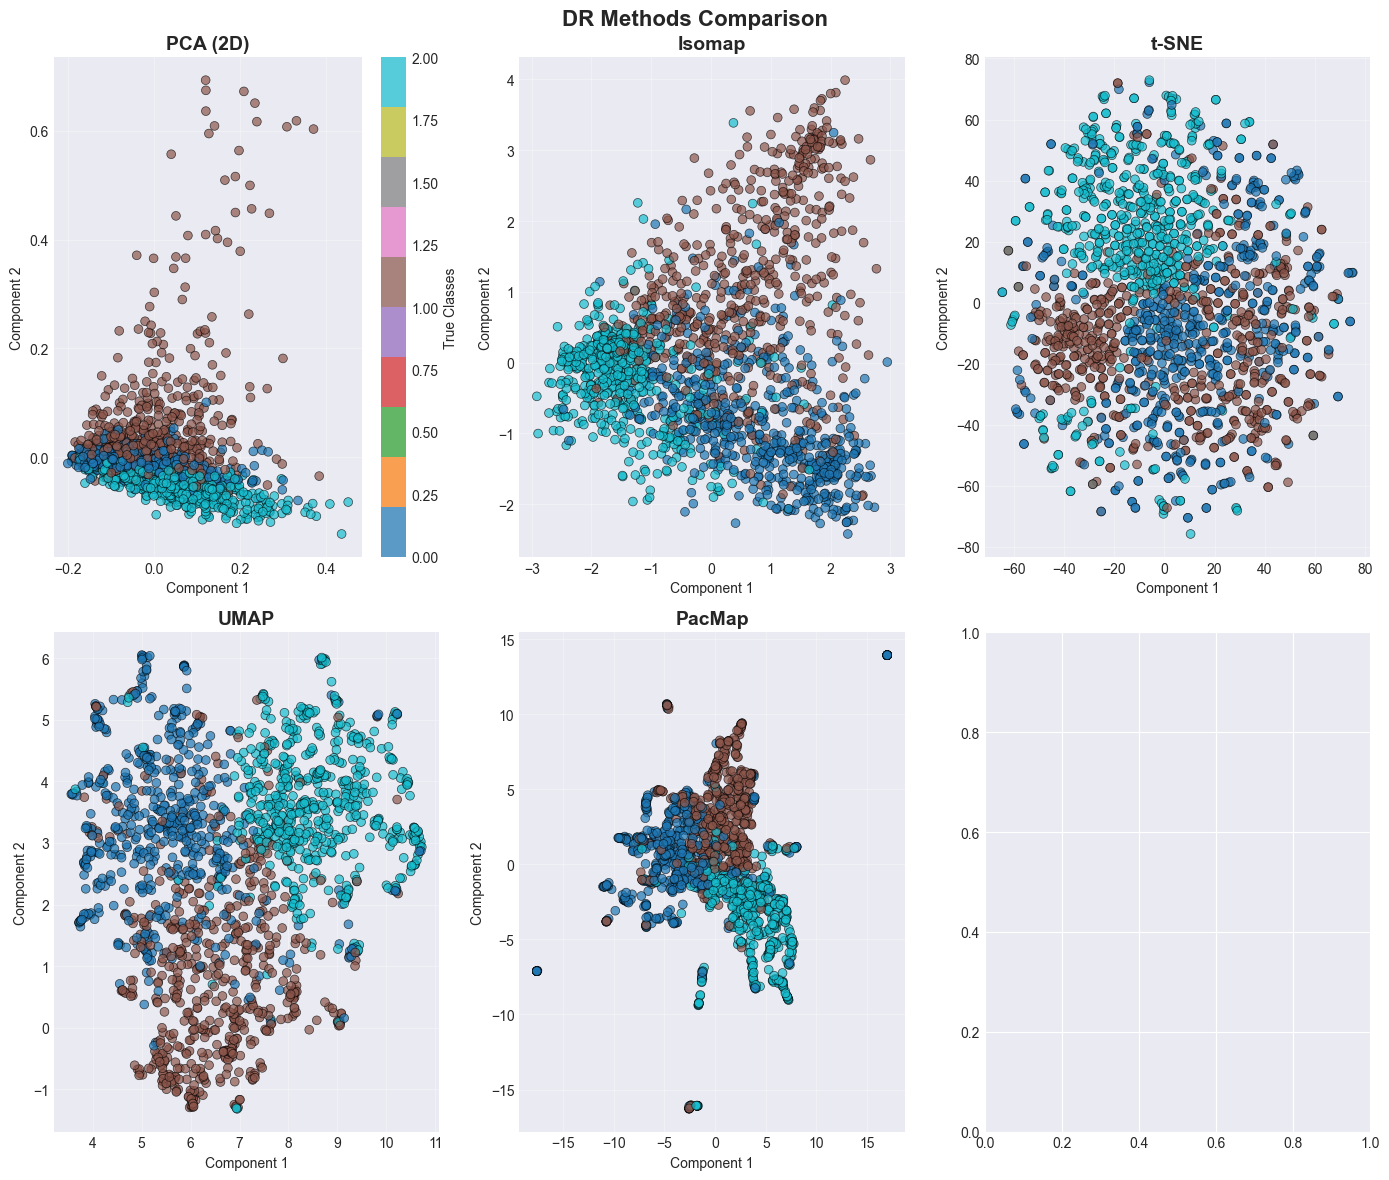

In [9]:
X_vect, target = load_dataset()

dr_comparer = DRComparer(random_state=42)
dr_results = dr_comparer.apply_all_methods(X_vect, n_components_2d=2)

print("\nВизуализация результатов DR-методов:")
visualize_dr_results(dr_results, target)

In [28]:
df, y_true = load_dataset()
dr_for_clustering = {k: v for k, v in dr_results.items() if k != 'PCA_2D'}

evaluator, comparison_results = compare_clustering_on_dr(dr_for_clustering, y_true, n_clusters=3)

Размерность: (1768, 26886)
Количество классов: 3

################################################################################
АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: PCA
################################################################################

DR Метод: PCA | Алгоритм: KMeans
Количество кластеров: 3

ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.5142
  Calinski-Harabasz Index: 1705.49
  Davies-Bouldin Index:    0.6719

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     0.0706
  Adjusted MI:             0.1040
  V-measure:               0.1051
    Homogeneity:           0.0881
    Completeness:          0.1304

DR Метод: PCA | Алгоритм: Agglomerative
Количество кластеров: 3

ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.4877
  Calinski-Harabasz Index: 1545.43
  Davies-Bouldin Index:    0.6886

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     0.0501
  Adjusted MI:             0.0663
  V-measure:               0.0675
    Homogeneity:           0.0566
    Completeness:          0.0836

DR Метод: PCA

In [10]:
sort_by = ['Silhouette', 'Calinski_Harabasz', 'ARI']
summary_df = evaluator.get_summary_dataframe()

print("\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("="*80)
print(summary_df.sort_values(by=sort_by, ascending=False).to_string())


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
   DR_Method           Algorithm  N_Clusters  Silhouette  Calinski_Harabasz  Davies_Bouldin       ARI       AMI  V_Measure
5     Isomap              KMeans           3    0.521253        2360.827427        0.643385  0.356733  0.355731   0.356418
0        PCA              KMeans           3    0.514247        1705.486271        0.671864  0.070585  0.104028   0.105137
9     Isomap  SpectralClustering           3    0.513961        2232.287117        0.640663  0.289587  0.323357   0.324097
10    Isomap               BRICH           3    0.497562        1977.907049        0.628057  0.218257  0.293530   0.294325
6     Isomap       Agglomerative           3    0.493372        1937.941361        0.634103  0.223012  0.300841   0.301625
4        PCA  SpectralClustering           3    0.489785        1399.204728        0.877096  0.093921  0.142533   0.143510
1        PCA       Agglomerative           3    0.487668        1545.428904        0.688578  0.050068  0.0663

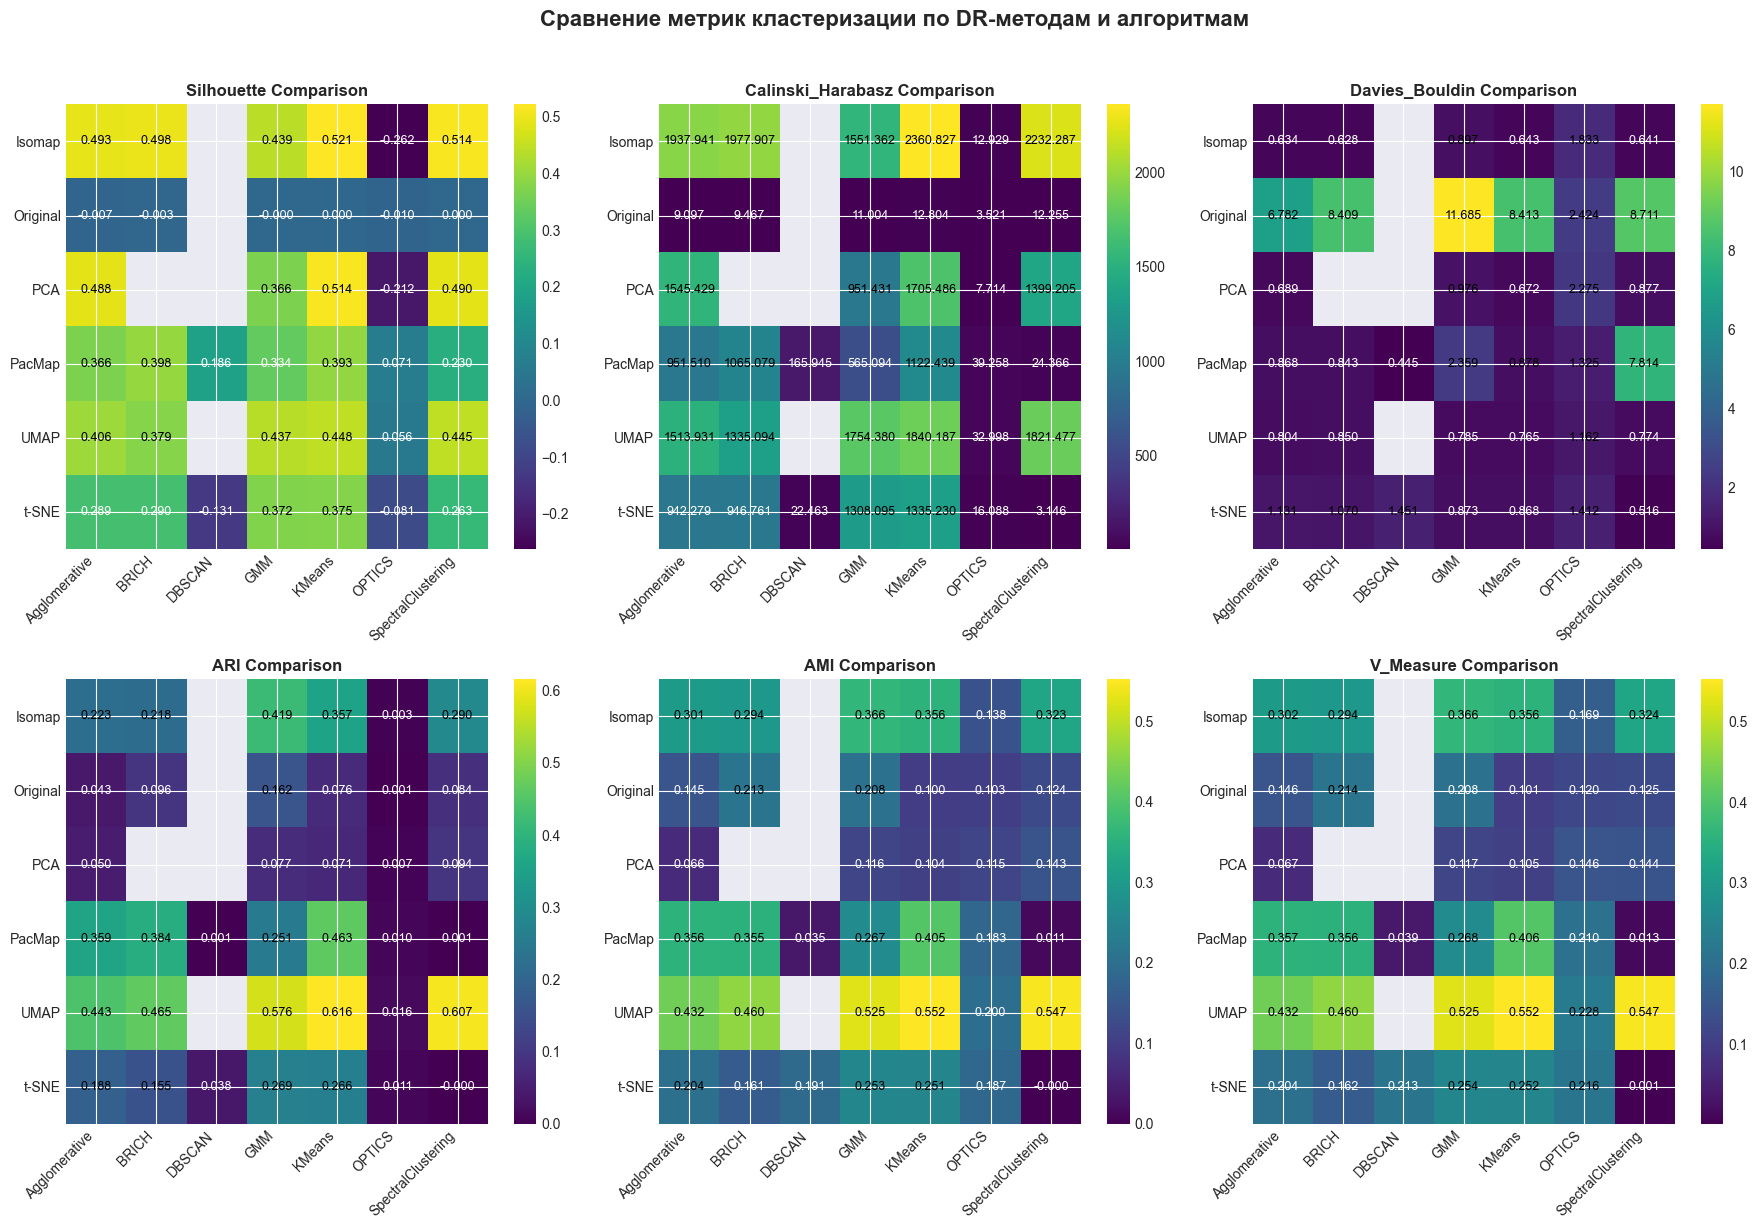

In [13]:
visualize_metrics_comparison(summary_df)

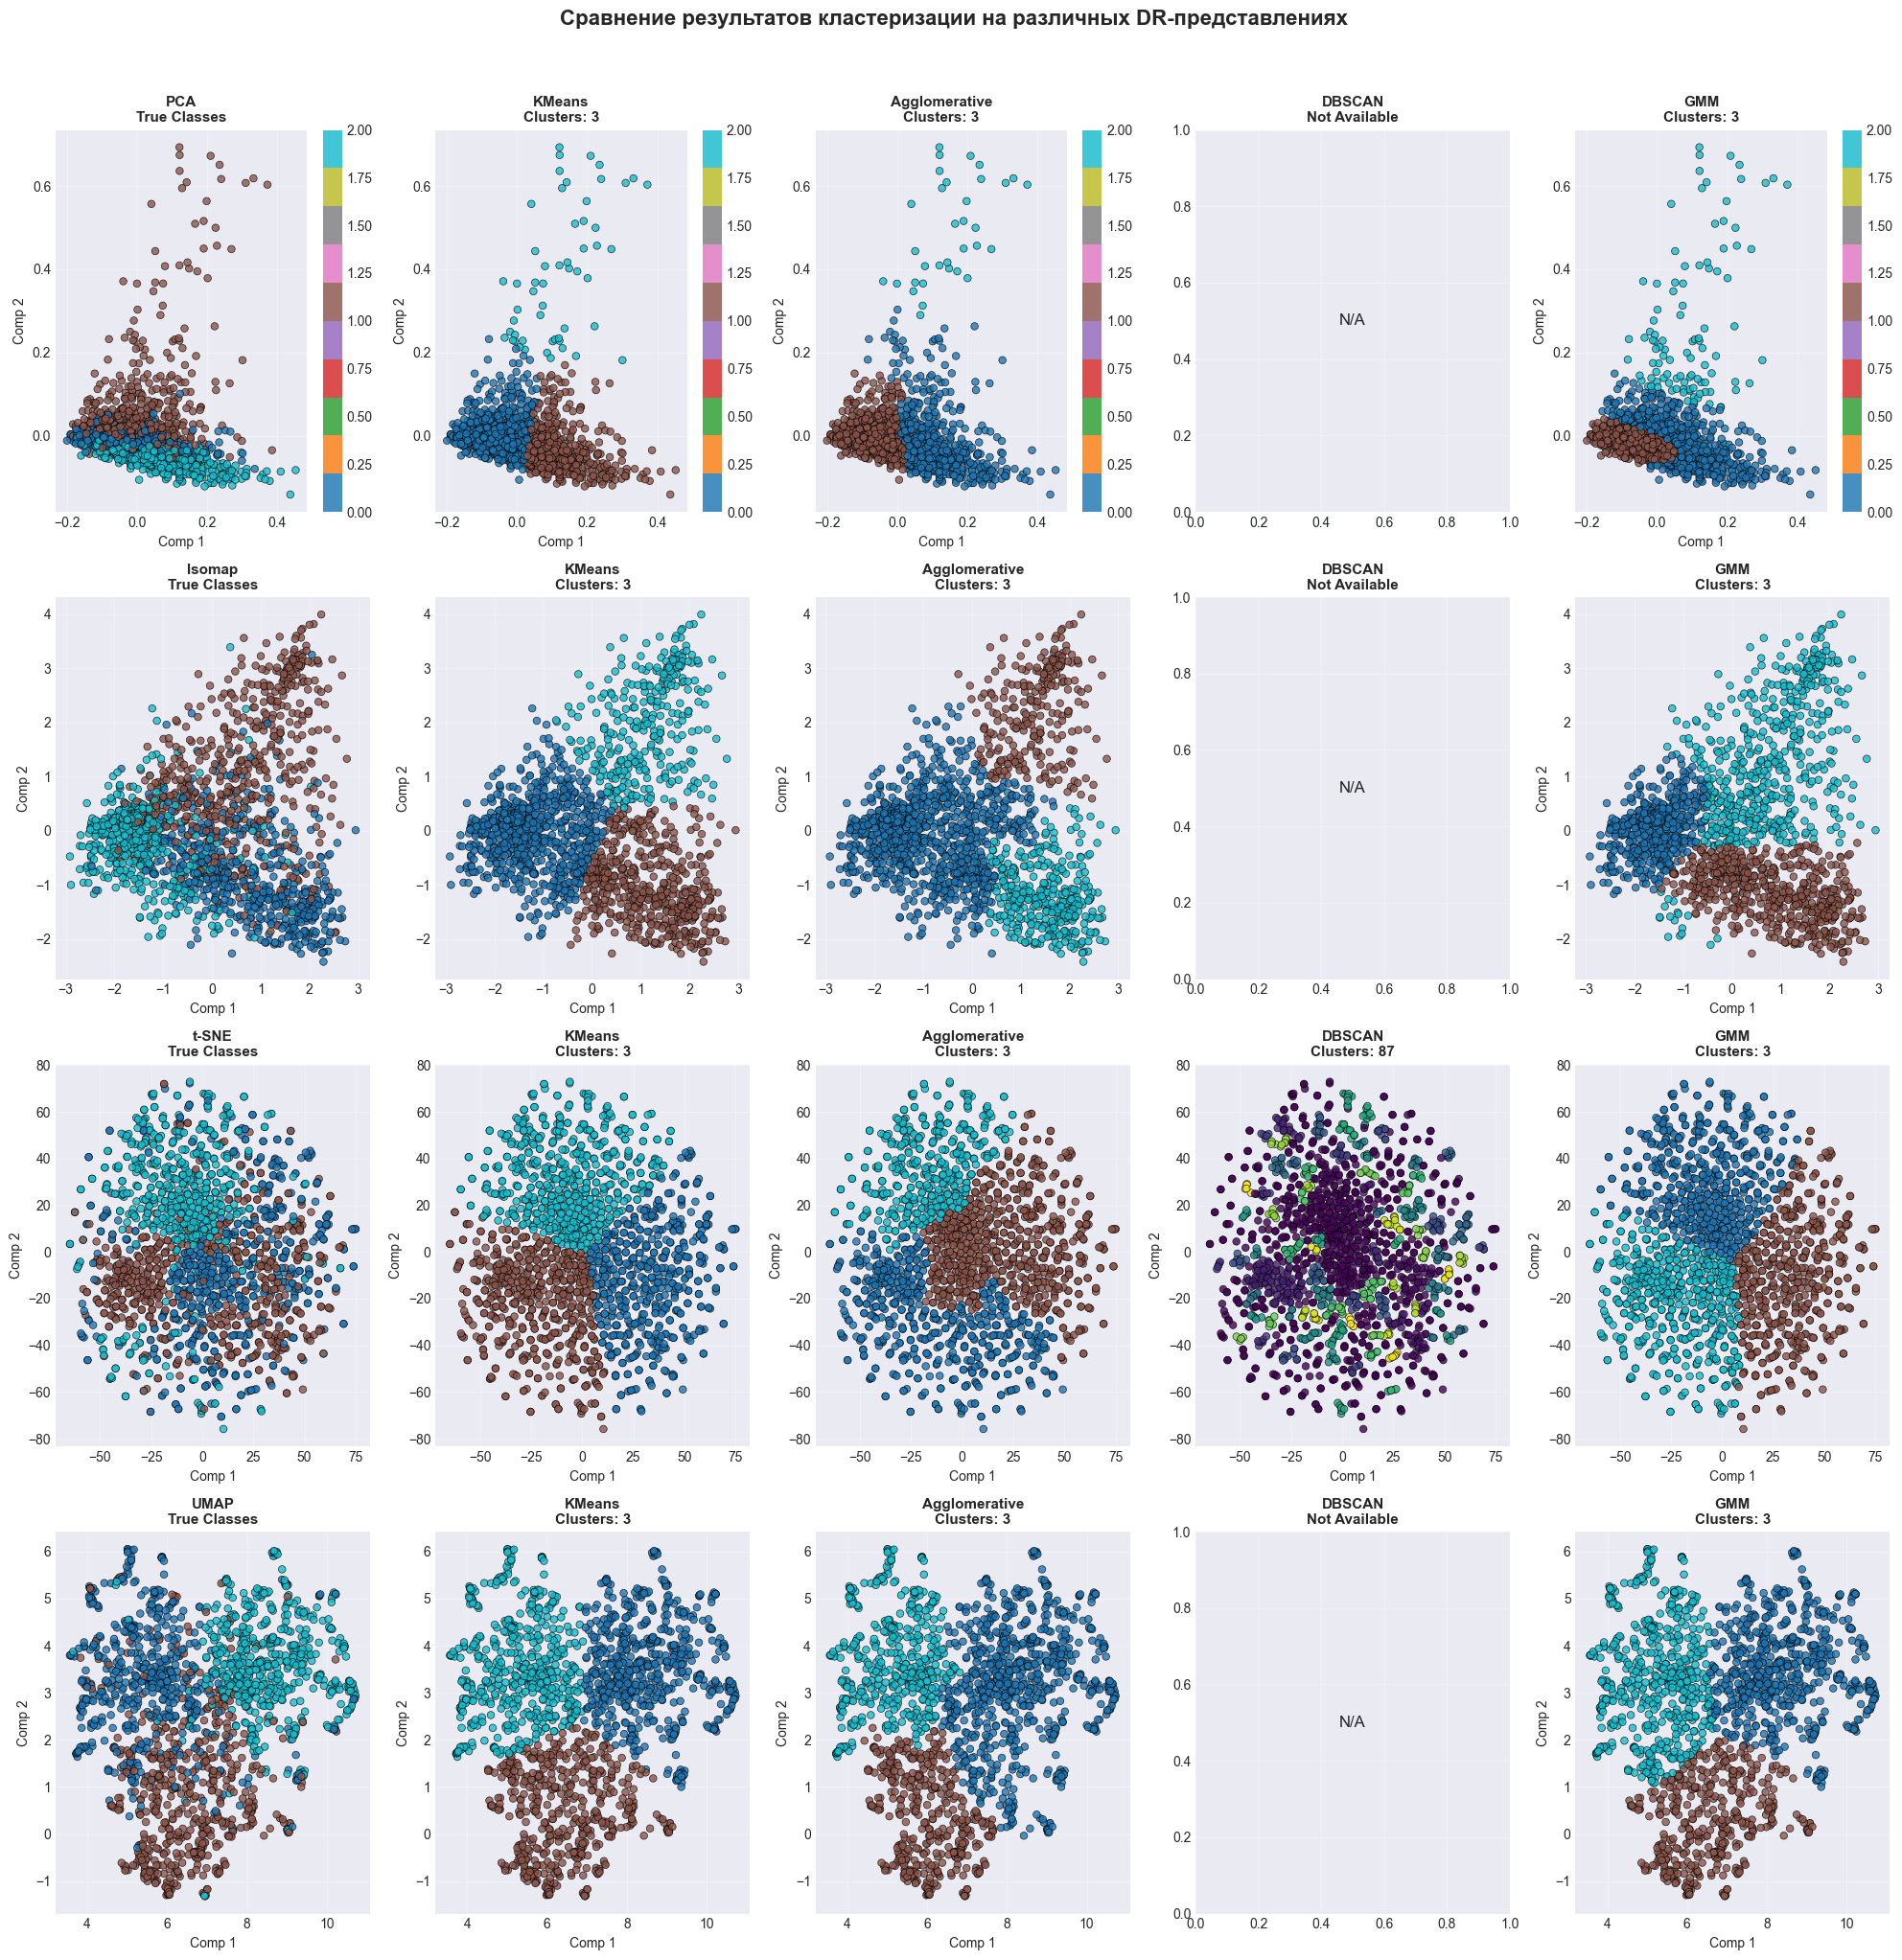

In [95]:
dr_methods_for_viz = ['PCA', 'Isomap', 't-SNE', 'UMAP']
dr_results_2d = {
    'PCA': dr_results['PCA_2D'],
    'Isomap': dr_results['Isomap'],
    't-SNE': dr_results['t-SNE'],
    'UMAP': dr_results['UMAP']
}
visualize_clustering_results_2d(dr_results_2d, y_true, evaluator, dr_methods_for_viz)

In [24]:
stability = evaluate_stability(dr_results, n_clusters=3, X_base=df, n_bootstrap=30)


################################################################################
ОЦЕНКА УСТОЙЧИВОСТИ НА ПРЕДСТАВЛЕНИИ: PCA
################################################################################
KMeans              : средний ARI = -0.0002 (±0.0058)
Agglomerative       : средний ARI = -0.0004 (±0.0069)
DBSCAN              : средний ARI = 1.0000 (±0.0000)
GMM                 : средний ARI = -0.0003 (±0.0034)
OPTICS              : средний ARI = 0.0000 (±0.0111)
SpectralClustering  : средний ARI = -0.0001 (±0.0042)
BIRCH               : средний ARI = 1.0000 (±0.0000)

################################################################################
ОЦЕНКА УСТОЙЧИВОСТИ НА ПРЕДСТАВЛЕНИИ: Isomap
################################################################################
KMeans              : средний ARI = -0.0002 (±0.0027)
Agglomerative       : средний ARI = 0.0001 (±0.0048)
DBSCAN              : средний ARI = 1.0000 (±0.0000)
GMM                 : средний ARI = 0.0000 (±0.0008)

KeyboardInterrupt: 

In [ ]:
df_orig = fetch_20newsgroups(subset='train', categories=['comp.graphics', 'rec.autos', 'comp.sys.ibm.pc.hardware'])


In [65]:
result_alg = comparison_results['Isomap']['KMeans']['labels'].copy()

In [ ]:
ind0 = np.where(result_alg == 1)[0]
ind1 = np.where(result_alg == 2)[0]
ind2 = np.where(result_alg == 0)[0]

* 0 - comp.graphics
* 1 - comp.sys.ibm.pc.hardware
* 2 - rec.autos

In [ ]:
print('Class=', df_orig.target[ind0[5]])
df_orig.data[ind0[5]].split('\n')[5:]

Class= 0


['',
 '\tHi, ',
 '',
 '\tIs anyone into medical imaging?  I have a good ray tracing background,',
 "and I'm interested in that field.  Could you point me to some sources?  Or",
 "better yet, if you have any experience, do you want to talk about what's",
 "going on or what you're working on?",
 '',
 'Thanks,',
 'Jason Freund',
 '']

In [102]:
print('Class=', df_orig.target[ind1[1]])
df_orig.data[ind1[1]].split('\n')[5:]

Class= 1


['X-Newsreader: Tin 1.1 PL5',
 '',
 'Andrew BW Colfelt (colfelt@ucsu.Colorado.EDU) wrote:',
 ': ',
 ': ',
 ': Shadow mask is when you put your face into',
 ': main memory.',
 ': ',
 '',
 'Keep your day job.',
 '',
 '']

In [116]:
print('Class=', df_orig.target[ind2[9]])
df_orig.data[ind2[9]].split('\n')[5:]

Class= 1


['Distribution: ba',
 'Lines: 22',
 '',
 "I'm in the market to upgrade my BIOS to a Phoenix 1.10 (got a new hard disk,",
 'discovered my BIOS doesn\'t have a "type 47") and I would like know where I',
 'can purchase one of these things.',
 '',
 "I checked with the motherboard manufacturer (for the curious-- it's from",
 'Mylex), and hearing the $60 figure prompted me to at least try to shop',
 'around...',
 '',
 "Problem is, I don't know where to shop around for something like this.",
 '',
 "I have heard that there's a BIOS speciality shop in the South Bay and it's",
 'been alleged that they advertise in the MicroTimes.',
 '',
 "Did find the MicroTimes, didn't find the ad or the shop.",
 '',
 'So, can anybody help me out on this quest?',
 '',
 'To anybody who replies to this-- Thanks in advance.',
 '',
 '-Jeff Chan\t\t\t\t\t| These are my opinions.  It',
 '\tjeff@ikos.com (*not* ikos@netcom.com)\t| would be quite silly if it',
 "\t..!netcom!ikos!jeff\t\t\t| was also my company's...",
 

По скольку в исходных данных 2 класса (0 и 1) схоже по тематики, то их часто путает.